In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from scipy.integrate import solve_ivp
from scipy.optimize import root_scalar
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Optimization

This section provides a peek into some of the optimization process that was performed when selecting network architectures and hyperparameters. 

Key highlights include:

1. **Architecture Experiments**  
   - Different layer sizes and numbers of hidden layers were tested to balance accuracy and training stability.  
   - Custom activation functions (e.g., Cosine, Tanh, SiLU, GELU) were evaluated for their ability to capture higher-order derivatives.

2. **Hyperparameter Tuning**  
   - Learning rates, number of epochs, and gradient clipping thresholds were adjusted to improve convergence.  
   - Early stopping criteria were implemented to avoid overfitting and save training time.

3. **Validation Strategy**  
   - Networks were benchmarked against quadrature solutions at key points in the domain (`t=0, t=0.5, t=1`) to ensure physical consistency.  
   - Multiple runs per configuration were performed to measure robustness and reproducibility.

4. **Visualization**  
   - Training loss curves and comparison plots against the quadrature solution were used to evaluate the performance of different architectures.

The accompanying **Optimization notebook** contains the actual experiments and visualizations for these tests.


### Model

This project uses a highly modularized `Net` class that allows for flexible experimentation with:

- **Different architectures**: You can specify any number of layers and neurons per layer.
- **Activation functions**: The network supports custom activations such as CosActivation, Tanh, SiLU, GELU, ReLU, etc.
- **Output scaling**: Minimum and maximum output bounds can be set based on sub- and super-solution estimates to enforce physically admissible solutions.

The default configuration corresponds to the best-performing architecture with:

- **Activation**: `CosActivation` (a custom cosine-based activation designed to better capture higher-order derivatives)
- **Scaling factors**: Set to the bounds for λ = 3.36
- **Layer sizes**: `[1, 32, 32, 32, 1]`

This modular design allows easy testing of different hyperparameters, architectures, and activation functions while maintaining stability and physical consistency.


In [ ]:
class CosActivation(nn.Module):
    def forward(self, x):
        return 0.5 * (1 - torch.cos(2 * torch.pi * x))


class Net(nn.Module):
    def __init__(self, layer_sizes=[1, 32, 32, 32, 1], activation=CosActivation, 
                 output_min=0.058579, output_max=0.259033):
        super(Net, self).__init__()
        self.output_min = output_min
        self.output_max = output_max
        
        layers = []
        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
            if i < len(layer_sizes) - 2:
                layers.append(activation())
        
        self.hidden = nn.Sequential(*layers)
        self.output_activation = nn.Sigmoid()

    def forward(self, t):
        raw = self.hidden(t)
        return self.output_min + (self.output_max - self.output_min) * self.output_activation(raw)

### Parameter Sets for Testing

To explore the flexibility and performance of the modular `Net` class, several parameter sets are defined. These sets allow testing of different:

- **$\lambda$ (lambda) values**: Controls the strength of the reaction term in the BVP.
- **$\rho$ (rho) values**: Used for mid-domain solution checks and scaling.
- **Initial conditions (`u0`)**: Starting value for the solution at t = 0.
- **Output bounds**: `output_min` and `output_max` derived from sub- and super-solutions.
- **Network architectures**: Different numbers of layers and neurons.
- **Activation functions**: CosActivation, Tanh, SiLU, GELU, ReLU, etc.

The parameter sets are organized into two groups:

1. **Parameter Sets 1**: Focused on varying $\lambda$, $\rho$, and output bounds while using the default architecture.
2. **Parameter Sets 2**: Designed to explore different layer sizes and activation functions for specific λ values.

These sets provide a comprehensive basis for evaluating the PINN’s performance, stability, and sensitivity to architecture choices.


In [ ]:
# Parameters
r = 1
gamma1 = 1

parameter_sets1 = [
    {
        'name': 'lambda_3.36',
        'lambd': 3.36251543,
        'rho': 0.19183673,
        'u0': 0.12950433,
        'output_min': 0.058579,
        'output_max': 0.259033,
    },
    {
        'name': 'lambda_5.85',
        'lambd': 5.84805224,
        'rho': 0.46734694,
        'u0': 0.28840600,
        'output_min': 0.127412,
        'output_max': 0.694759,
    },
    {
        'name': 'lambda_9.53',
        'lambd': 9.53230192,
        'rho': 0.65102041,
        'u0': 0.36987505,
        'output_min': 0.158089,
        'output_max': 1.073834,
    },
    {
        'name': 'lambda_19.38',
        'lambd': 19.37997763,
        'rho': 0.83469388,
        'u0': 0.42421198,
        'output_min': 0.167799,
        'output_max': 1.666294,
    },
    {
        'name': 'lambda_35.26',
        'lambd': 35.26398748,
        'rho': 0.92653061,
        'u0': 0.43838751,
        'output_min': 0.156112,
        'output_max': 2.256968,
    }
]

parameter_sets2 = [
    {
        'name': 'lambda_3.36',
        'lambd': 3.36251543,
        'rho': 0.19183673,
        'u0': 0.12950433,
        'layer_sizes': [1, 16, 32, 64, 1],
        'activation': nn.Tanh,
    },
    {
        'name': 'lambda_3.36',
        'lambd': 3.36251543,
        'rho': 0.19183673,
        'u0': 0.12950433,
        'layer_sizes': [1, 16, 16, 16, 16, 16, 1],
        'activation': nn.SiLU,
    },
    {
        'name': 'lambda_9.53',
        'lambd': 9.53230192,
        'rho': 0.65102041,
        'u0': 0.36987505,
        'output_min': 0.158089,
        'output_max': 1.073834,
        'activation': nn.ReLU,
    },
    {
        'name': 'lambda_35.26',
        'lambd': 35.26398748,
        'rho': 0.92653061,
        'u0': 0.43838751,
        'output_min': 0.156112,
        'output_max': 2.256968,
        'layer_sizes': [1, 32, 32, 1],
    },
    {
        'name': 'lambda_35.26',
        'lambd': 35.26398748,
        'rho': 0.92653061,
        'u0': 0.43838751,
        'output_min': 0.156112,
        'output_max': 2.256968,
        'activation': nn.GELU,
    }
]

### Loss Function, Training, Evaluating

This section covers the core workflow for training the Physics-Informed Neural Network (PINN) and evaluating its performance:

1. **Loss Function**  
   The loss function combines three contributions:
   - **Equation loss (`loss_eq`)**: Measures how well the network satisfies the differential equation at collocation points.
   - **Boundary condition losses (`loss_bc_0` and `loss_bc_1`)**: Enforce the boundary conditions at t = 0 and t = 1.
   
   Gradients are computed with `torch.autograd.grad` to enable automatic differentiation for higher-order derivatives.

2. **Training the Network**  
   - Networks are trained using Adam optimizer with optional learning rate schedulers.
   - Gradient clipping is applied to maintain stability.
   - Early stopping is implemented to terminate training if no improvement occurs for a specified patience interval.
   - Multiple runs can be performed per parameter set to check robustness.

3. **Evaluating the Results**  
   - The trained network is evaluated over a dense grid (`t_test`) to produce predictions.
   - Quadrature solutions are computed using `solve_ivp` for comparison.
   - Average differences at key points (t = 0, 0.5, 1) are computed to assess accuracy.
   - Loss curves and solution plots are generated for visual inspection of convergence and fidelity.

This structured approach ensures that each trained network is physically consistent and can be benchmarked against high-precision numerical solutions.



RUNNING EXPERIMENTS FOR: lambda_3.36
Early stopping at epoch 615 | Best loss: 0.000056
Run: 1 / 1
Number of passed models: 1
Number of failed models: 0
Average differences for {'name': 'lambda_3.36', 'lambd': 3.36251543, 'rho': 0.19183673, 'u0': 0.12950433, 'output_min': 0.058579, 'output_max': 0.259033, 'min_delta': 0.0001}:
t=0: 0.00337670, t=0.5: 0.00471289, t=1: 0.00343753
Total Time: 0.17 min, Avg per run: 10.44 sec
------------------------------------------------------------


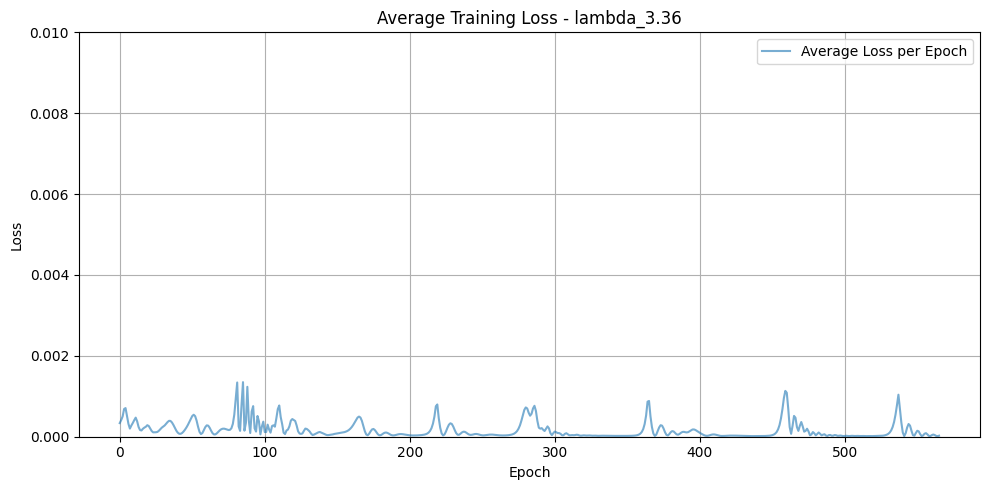

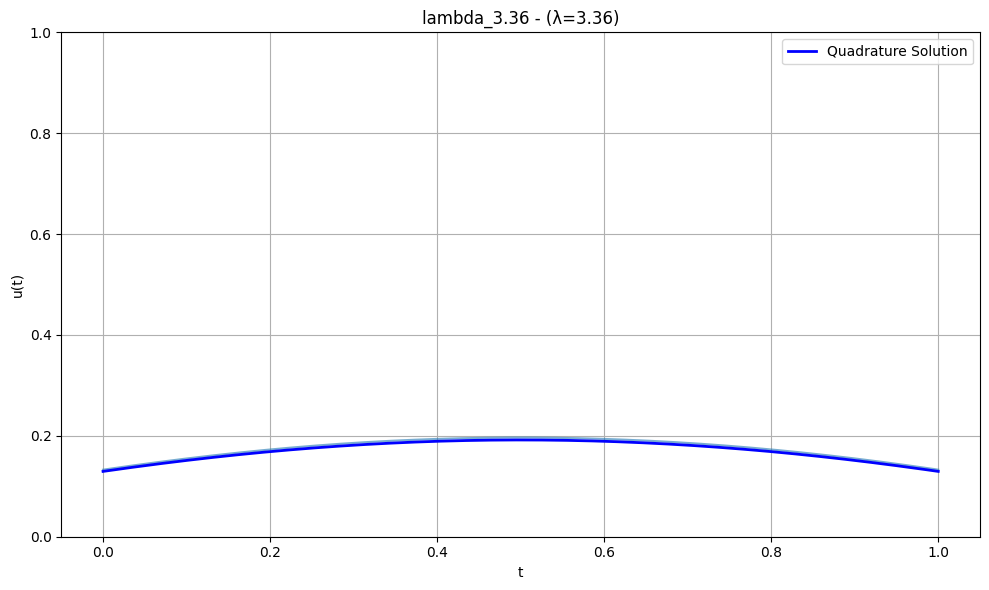


RUNNING EXPERIMENTS FOR: lambda_5.85
Early stopping at epoch 1029 | Best loss: 0.001076
Run: 1 / 1
Number of passed models: 1
Number of failed models: 0
Average differences for {'name': 'lambda_5.85', 'lambd': 5.84805224, 'rho': 0.46734694, 'u0': 0.288406, 'output_min': 0.127412, 'output_max': 0.694759, 'min_delta': 0.001}:
t=0: 0.00050582, t=0.5: 0.00140652, t=1: 0.00065710
Total Time: 0.32 min, Avg per run: 19.07 sec
------------------------------------------------------------


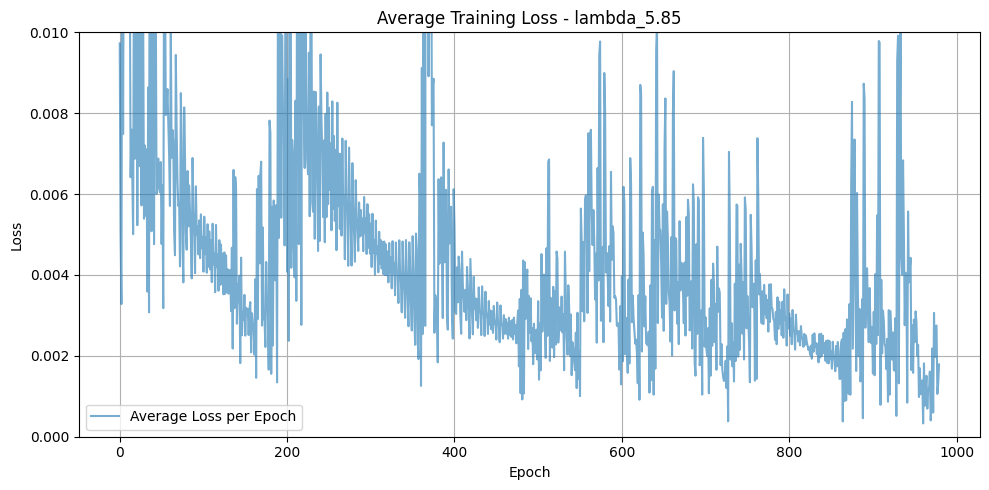

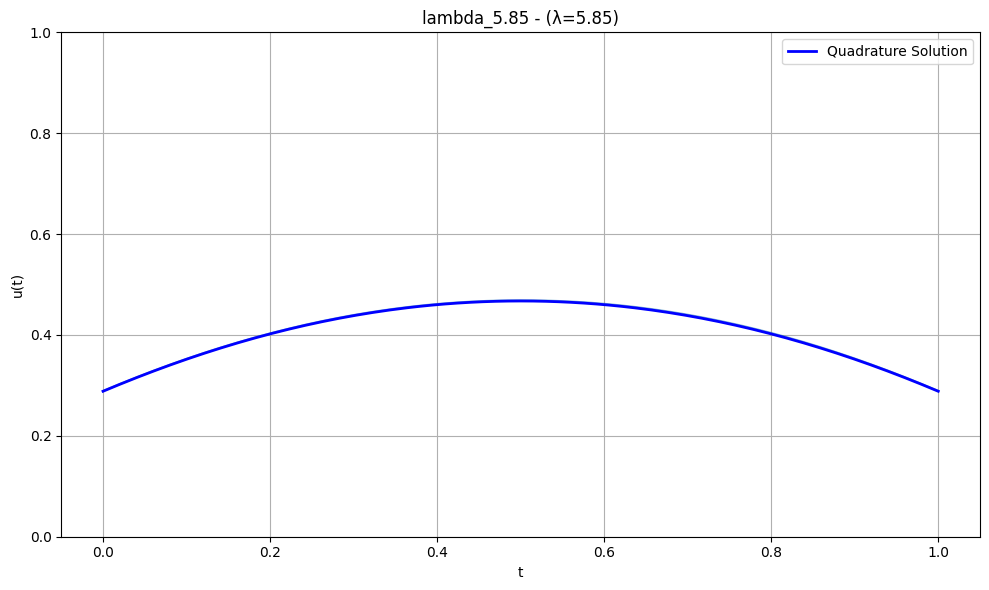


RUNNING EXPERIMENTS FOR: lambda_9.53
Early stopping at epoch 1473 | Best loss: 0.002182
Run: 1 / 1
Number of passed models: 1
Number of failed models: 0
Average differences for {'name': 'lambda_9.53', 'lambd': 9.53230192, 'rho': 0.65102041, 'u0': 0.36987505, 'output_min': 0.158089, 'output_max': 1.073834, 'min_delta': 0.001}:
t=0: 0.00059446, t=0.5: 0.00071150, t=1: 0.00257524
Total Time: 0.44 min, Avg per run: 26.10 sec
------------------------------------------------------------


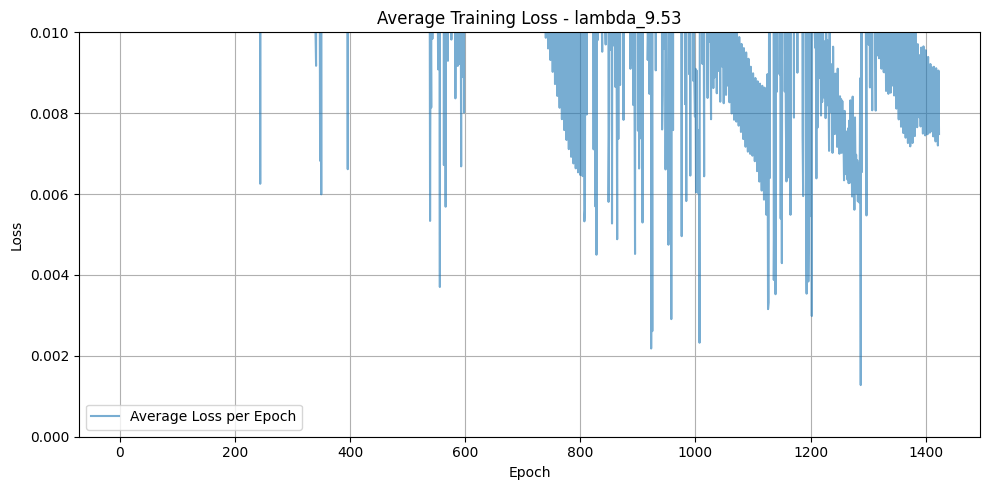

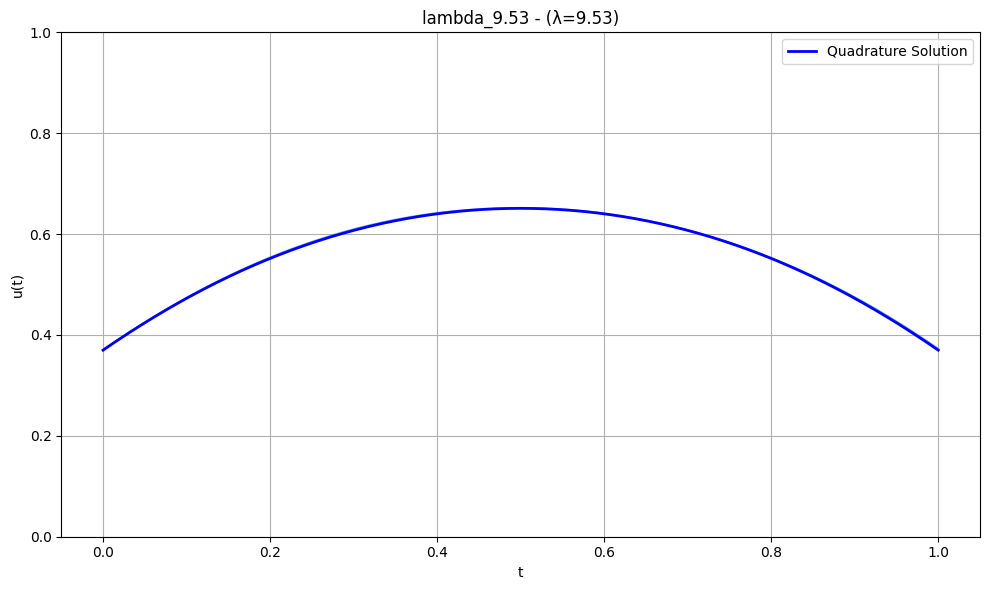


RUNNING EXPERIMENTS FOR: lambda_19.38
Early stopping at epoch 1863 | Best loss: 0.002656
Run: 1 / 1
Number of passed models: 1
Number of failed models: 0
Average differences for {'name': 'lambda_19.38', 'lambd': 19.37997763, 'rho': 0.83469388, 'u0': 0.42421198, 'output_min': 0.167799, 'output_max': 1.666294, 'min_delta': 0.001}:
t=0: 0.00181553, t=0.5: 0.00156841, t=1: 0.00318006
Total Time: 0.54 min, Avg per run: 32.21 sec
------------------------------------------------------------


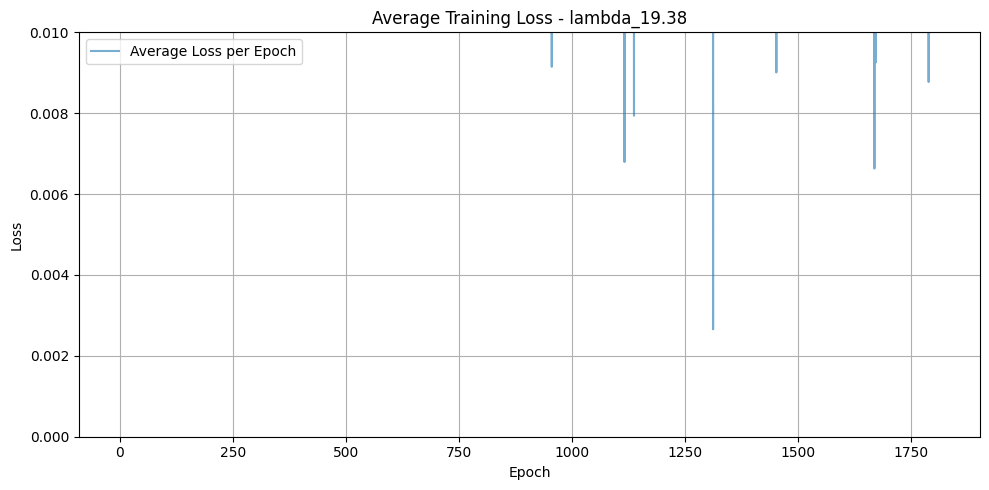

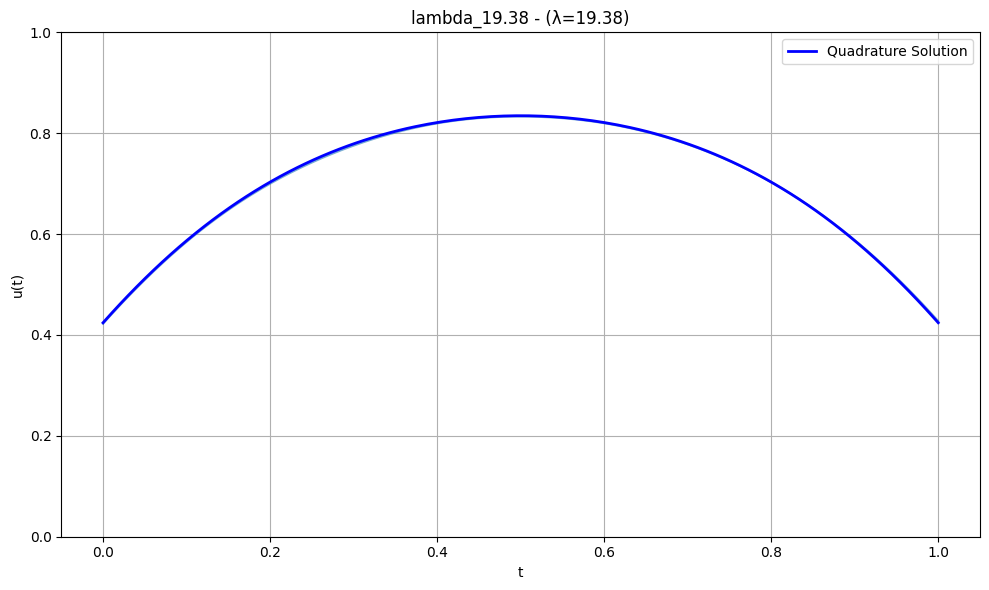


RUNNING EXPERIMENTS FOR: lambda_35.26
Early stopping at epoch 2267 | Best loss: 0.008208
Run: 1 / 1
Number of passed models: 1
Number of failed models: 0
Average differences for {'name': 'lambda_35.26', 'lambd': 35.26398748, 'rho': 0.92653061, 'u0': 0.43838751, 'output_min': 0.156112, 'output_max': 2.256968, 'min_delta': 0.001}:
t=0: 0.00351101, t=0.5: 0.00047792, t=1: 0.00010466
Total Time: 0.61 min, Avg per run: 36.63 sec
------------------------------------------------------------


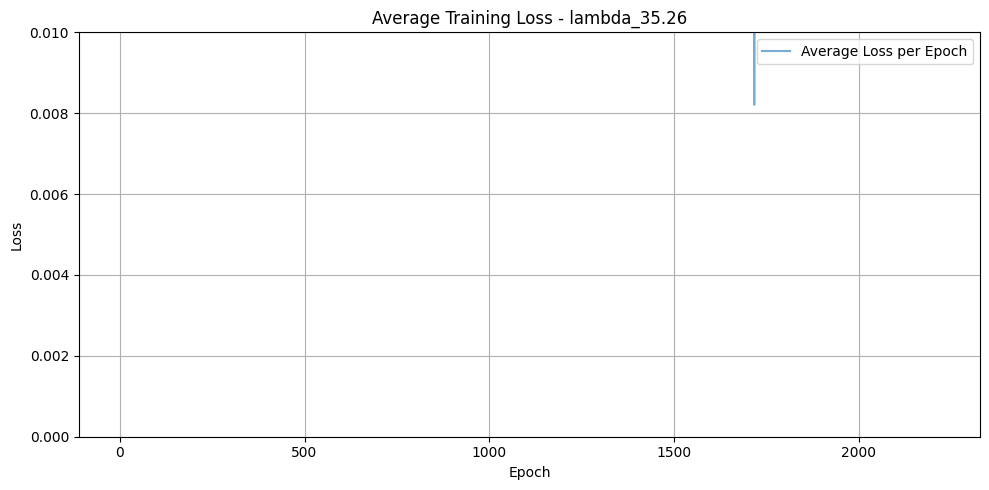

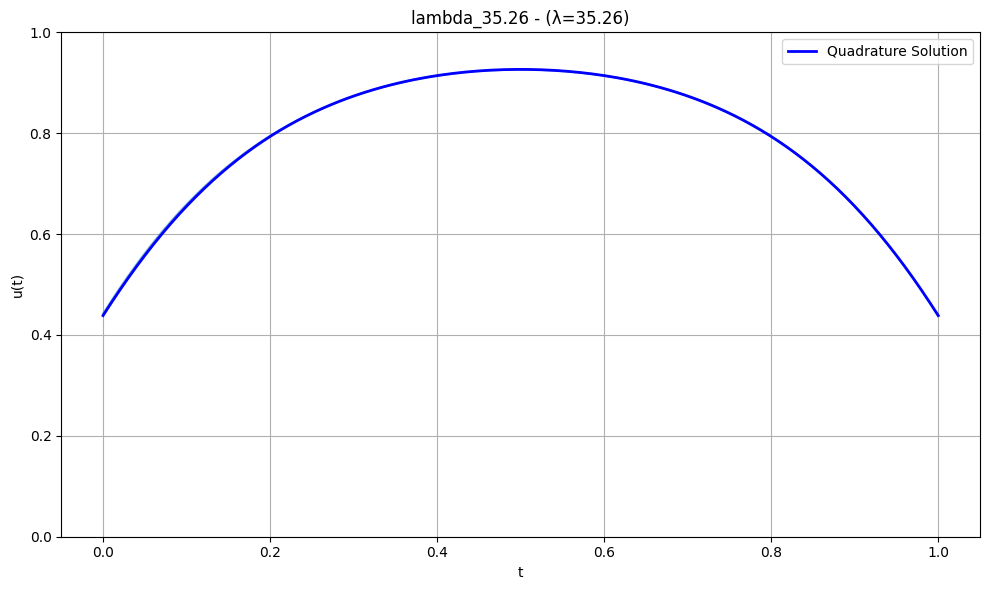


ALL EXPERIMENTS COMPLETED


In [ ]:
def loss_function(u_pred, t, net, params):
    u_t = u_pred
    u_t_grad = torch.autograd.grad(u_pred, t, torch.ones_like(u_pred), create_graph=True)[0]
    u_t_grad2 = torch.autograd.grad(u_t_grad, t, torch.ones_like(u_t_grad), create_graph=True, allow_unused=True)[0]
    
    lambd = params['lambd']
    
    f = -u_t_grad2 - lambd * r * u_t * (1 - u_t)
    loss_eq = torch.mean(f**2)
    
    t_0 = torch.tensor([[0.0]], dtype=torch.float32, requires_grad=True, device=device)
    t_1 = torch.tensor([[1.0]], dtype=torch.float32, requires_grad=True, device=device)
    u_0 = net(t_0)
    u_1 = net(t_1)
    
    u_0_grad = torch.autograd.grad(u_0, t_0, torch.ones_like(u_0), create_graph=True)[0]
    u_1_grad = torch.autograd.grad(u_1, t_1, torch.ones_like(u_1), create_graph=True)[0]
    
    loss_bc_0 = ((-u_0_grad + torch.sqrt(torch.tensor(lambd, device=device)) * gamma1 * u_0) ** 2).mean()
    loss_bc_1 = ((u_1_grad + torch.sqrt(torch.tensor(lambd, device=device)) * gamma1 * u_1) ** 2).mean()
    
    return loss_eq, loss_bc_1, loss_bc_0


def train_model(net, optimizer, run_num, params, param_name, scheduler=None, n_epochs=3000, patience=500):
    t_values = torch.linspace(0, 1, 500, device=device).view(-1, 1)
    t_values.requires_grad_()
    losses = []
    best_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(n_epochs):
        optimizer.zero_grad()
        u_pred = net(t_values)
        loss_eq, loss_bc_0, loss_bc_1 = loss_function(u_pred, t_values, net, params)

        total_loss = loss_eq + loss_bc_0 + loss_bc_1

        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)
        optimizer.step()
        if scheduler is not None:
            scheduler.step()
        
        loss_val = total_loss.item()

        if epoch >= 50:
            losses.append(total_loss.item())
        
        if loss_val < best_loss:
            best_loss = loss_val
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch} | Best loss: {best_loss:.6f}")
            break


    return net(t_values).detach().cpu().numpy().flatten(), losses


def F(u):
    return 0.5 * u**2 - (1/3) * u**3


def ode1(t, u, rho, lambd):
    val = 2 * lambd * r *(F(rho) - F(u))
    return np.sqrt(np.maximum(val, 0))



parameter_sets = parameter_sets2 # Choose an example parameter sets (parameter_sets1 or parameter_sets2)

N_RUNS = 10
t_test = np.linspace(0, 1, 500)

# Main loop: iterate through each parameter set
for params in parameter_sets:
    print("\n" + "="*80)
    print(f"RUNNING EXPERIMENTS FOR: {params['name']}")
    print("="*80)
    
    # Extract parameters
    lambd = params['lambd']
    rho = params['rho']
    u0 = params['u0']
    output_min = params.get('output_min', 0.167799)
    output_max = params.get('output_max', 1.666294)
    layer_sizes = params.get('layer_sizes', [1, 32, 32, 32, 1])
    activation = params.get('activation', CosActivation)

    # Compute quadrature solution for this parameter set
    sol1 = solve_ivp(ode1, [0, 0.5], [u0], args=(rho, lambd), 
                     dense_output=True, rtol=1e-9, atol=1e-12)
    t1 = np.linspace(0, 0.5, 100)
    u1 = sol1.sol(t1)
    t2 = 1 - t1
    u2 = u1[:, ::-1]
    
    t_quad = np.concatenate([t1, t2[::-1]])
    u_quad = np.concatenate([u1.flatten(), u2.flatten()])
    
    # Loop through layer configurations
    start_time = time.time()
    all_outputs = []
    all_losses = []
    passed_runs = 0
    failed_runs = 0

    for i in range(N_RUNS):
        net = Net(output_min=output_min, 
                    output_max=output_max, activation=activation, layer_sizes=layer_sizes).to(device)
        optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
        try:
            output, losses = train_model(net, optimizer, i+1, params, params['name'], scheduler=None, n_epochs=5000)
            all_outputs.append(output)
            all_losses.append(losses)
        except Exception as e:
            print(f"Run {i+1} failed: {e}")
            failed_runs += 1
            continue

        t_tensor = torch.tensor(t_test, dtype=torch.float32, device=device).unsqueeze(1)
        u_pred_test = net(t_tensor).detach().cpu().numpy().flatten()
        idx_05 = np.argmin(np.abs(t_test - 0.5))

        if abs(rho - u_pred_test[idx_05]) < 1e-2:
            passed_runs += 1
            
        else:
            failed_runs += 1

        print(f"Run: {i + 1} / {N_RUNS}", end='\r')
    

    print(f"\nNumber of passed models: {passed_runs}")
    print(f"Number of failed models: {failed_runs}")

    all_outputs = np.array(all_outputs)
    idx_05 = np.argmin(np.abs(t_test - 0.5))

    diffs_0 = [abs(u0 - output[0]) for output in all_outputs]
    diffs_05 = [abs(rho - output[idx_05]) for output in all_outputs]
    diffs_1 = [abs(u0 - output[-1]) for output in all_outputs]

    avg_diff_0 = np.mean(diffs_0)
    avg_diff_05 = np.mean(diffs_05)
    avg_diff_1 = np.mean(diffs_1)

    print(f"Average differences for {params}:")
    print(f"t=0: {avg_diff_0:.8f}, t=0.5: {avg_diff_05:.8f}, t=1: {avg_diff_1:.8f}")
    
    end_time = time.time()
    elapsed = end_time - start_time
    ave_elap = elapsed / N_RUNS
    elap_min = elapsed / 60
    print(f"Total Time: {elap_min:.2f} min, Avg per run: {ave_elap:.2f} sec")
    print("-" * 60)

    # Plot results
    all_losses = np.array(all_losses) 
    avg_losses = np.mean(all_losses, axis=0)
    plt.figure(figsize=(8, 4))
    plt.plot(avg_losses, label='Average Loss per Epoch', alpha=0.6)
    plt.title(f"Average Training Loss - {params['name']}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.ylim(0, 1e-2)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(8, 4))
    for j, output in enumerate(all_outputs):
        plt.plot(t_test, output, alpha=0.6)
    plt.plot(t_quad, u_quad, label="Quadrature Solution", color="blue", linewidth=2)
    plt.title(f"{params['name']} - (λ={lambd:.2f})")
    plt.xlabel("t")
    plt.ylabel("u(t)")
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

print("\n" + "="*80)
print("ALL EXPERIMENTS COMPLETED")
print("="*80)